# 1 Motivation

The data set is on Motor Vehicle Collisons in New York City obtained from NYC OpenData and collected by the NYPD. It consist of all the incidents happening from June 2012 up till today. It has more than a million rows and 29 columnn with data types such as geospatial, datetime, vehicle type, factor type, etc.

The data set ended up being the basis for the project because of its data type variety that seemed great for the task in question - both for the exploratory analysis, the machine learning and the visualisations. Furthermore, it seemed like a data set where one would be able to find minor but very interesting patterns. 

The goal for the end user's experience is to allow the user to do some findings herself instead of just reading about the ones already found for this project. It would be great to provoke the "Aha - that's funny/interesting"-thought in somebody else. 

# 2 Basic Stats

## Data Cleaning

This subsection will explain how the data was cleaned, what was removed and what was added. 

Most of this is pretty straightforward and will mainly be described by a few  inline comments, but in between some of the code cells will be elaborative comments.

In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from collections import Counter
import csv
from operator import itemgetter
import seaborn as sns
sns.set(style="dark")
from datetime import date
import warnings
warnings.filterwarnings('ignore')
import geoplotlib
from geoplotlib.utils import BoundingBox
from __future__ import division
from __future__ import print_function
%matplotlib inline

In [2]:
# load data
df = pd.read_csv('NYPD_Motor_Vehicle_Collisions.csv')

In [3]:
# rename all the columns to lower case
df.rename(columns=lambda x: x.lower(), inplace=True)

The number of NaN cells were counted to get an overview of the data and to bette decide what to leave out.

In [4]:
# count NaN cells to get an overview of null values
for c in df.columns:
    quantity = len(df[df[c].isnull()])
    percentage = quantity/len(df)*100
    print("{}: {} ({:.2f})".format(c, quantity, percentage))

date: 0 (0.00)
time: 0 (0.00)
borough: 265752 (26.45)
zip code: 265812 (26.46)
latitude: 202193 (20.13)
longitude: 202193 (20.13)
location: 202193 (20.13)
on street name: 167217 (16.65)
cross street name: 191345 (19.05)
off street name: 863232 (85.93)
number of persons injured: 0 (0.00)
number of persons killed: 0 (0.00)
number of pedestrians injured: 0 (0.00)
number of pedestrians killed: 0 (0.00)
number of cyclist injured: 0 (0.00)
number of cyclist killed: 0 (0.00)
number of motorist injured: 0 (0.00)
number of motorist killed: 0 (0.00)
contributing factor vehicle 1: 4080 (0.41)
contributing factor vehicle 2: 126459 (12.59)
contributing factor vehicle 3: 938722 (93.44)
contributing factor vehicle 4: 990342 (98.58)
contributing factor vehicle 5: 1001116 (99.65)
unique key: 0 (0.00)
vehicle type code 1: 5307 (0.53)
vehicle type code 2: 139884 (13.92)
vehicle type code 3: 940031 (93.57)
vehicle type code 4: 990731 (98.62)
vehicle type code 5: 1001194 (99.66)


A few helper functions were created to ease feature extraction and the following creation of new columns.

In [5]:
# helper functions for feature extraction
def split_date(string, index):
    return int(string.split("/")[index])

def get_hour(string):
    return string.split(":")[0]
    
def get_weekday(string):
        d = string.split("/")
        return date(int(d[2]), int(d[0]), int(d[1])).weekday()

In [6]:
# create new columns
df["day"] = df["date"].apply(lambda x: split_date(x,1))
df["month"] = df["date"].apply(lambda x: split_date(x,0))
df["year"] = df["date"].apply(lambda x: split_date(x,2))
df["hour"] = df["time"].apply(lambda x: get_hour(x))
df["weekday"] = df["date"].apply(lambda x: get_weekday(x))

Based on the overview of the missing values, the newly created columns and the analyses that are intended to be performed, some columns are left out. And instead of having incomplete data from 2012 and 2017, those rows are also dropped. 

In [7]:
df.drop(["time",
         "location", "unique key", "contributing factor vehicle 3", 
         "contributing factor vehicle 4", "contributing factor vehicle 5",
         "off street name", "vehicle type code 3", "vehicle type code 4", 
         "vehicle type code 5"], axis=1, inplace=True)

In [8]:
Counter(df[df["year"] == 2016]["month"])

Counter({1: 18100,
         2: 15983,
         3: 18517,
         4: 18331,
         5: 20052,
         6: 19435,
         7: 19867,
         8: 19678,
         9: 19491,
         10: 19666,
         11: 19317,
         12: 19215})

In [9]:
df = df[(-df["year"].isin([2012,2017]))]
df = df[df["longitude"].notnull() & df["longitude"] > -80]
df = df[df["borough"].notnull() | df["zip code"].notnull()]

In [12]:
# rename for the sake of geoplotlib and other libraries recognising "lon" and "lat"
df.rename(columns={"longitude": "lon", "latitude": "lat"}, inplace=True)

# drop any rows with missing "lon" or "lat" values
df = df[df["lon"].notnull()]

In [13]:
# set the text variables to have title case instead of all capital letters
df["borough"] = df["borough"].apply(lambda x: x.title())
df["vehicle type code 1"] = df["vehicle type code 1"].apply(lambda x: x.title() if type(x) is str else x)
df["on street name"] = df["on street name"].apply(lambda x: x.title().strip() if type(x) is str else x)
df["cross street name"] = df["cross street name"].apply(lambda x: x.title().strip() if type(x) is str else x)

In [14]:
# save data to a csv file
df.to_csv(path_or_buf="new_clean_data.csv", index=False)
clean_df = df.copy()

## Basic Stats

This subsection will show some the underlying basic statistics of the data set.

In [15]:
# simply for overview of the different columns
print("Data frame columns")
print("------------------")
for c in df.columns:
    print(c)

Data frame columns
------------------
date
borough
zip code
lat
lon
on street name
cross street name
number of persons injured
number of persons killed
number of pedestrians injured
number of pedestrians killed
number of cyclist injured
number of cyclist killed
number of motorist injured
number of motorist killed
contributing factor vehicle 1
contributing factor vehicle 2
vehicle type code 1
vehicle type code 2
day
month
year
hour
weekday


After removing a whole lot of rows in the previous subsection, the number of incidents left in the data set is now:

In [16]:
print(len(df))

601311


The incidents are distributed among the five boroughs in New York City the following way

In [17]:
print("Incident count per borough")
print("--------------------------")
for borough, count in Counter(df["borough"]).items():
    print(borough + ": " + str(count))

Incident count per borough
--------------------------
Bronx: 78176
Brooklyn: 184622
Staten Island: 26770
Manhattan: 155786
Queens: 155957


This looks like the following when turned into a bar plot, where you easilier see the relative differences in the distribution among the boroughs.

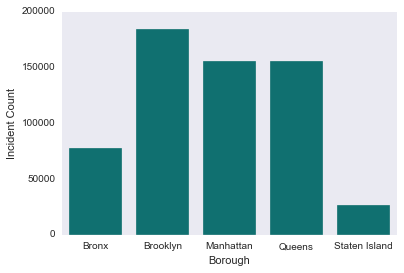

In [18]:
c_hours = Counter(df["borough"])
c_hours_ints = [(k,v) for (k,v) in c_hours.items()]
sorted_c = sorted(c_hours_ints)
x = [k.title() for k,_ in sorted_c]
y = [v for _,v in sorted_c]
test = pd.DataFrame( 
    {
        "x": x,
        "y": y
    }
)

g = sns.barplot(x="x", y="y", data=test, color="teal")
g.set(xlabel='Borough', ylabel='Incident Count')
plt.show()

To add a bit more perspective than just the counts of the accidents, the population counts of the different boroughs were added as a measure.

In [19]:
# population numbers taken from https://www.citypopulation.de/php/usa-newyorkcity.php
population_dict = {
                   "Bronx": 1455720,
                   "Brooklyn": 2629150,
                   "Manhattan": 1643734,
                   "Queens": 2333054,
                   "Staten Island": 476015
                  }

# dictionary of containing the number of accidents for each borough
accident_dict = Counter(df["borough"])

# dictionary containing the number of accidents involving injury or death for each borough
df_injury_or_death = df[(df["number of persons injured"] > 0) | (df["number of persons killed"] > 0)]
injury_or_death_dict = Counter(df_injury_or_death["borough"])

Hereby, a look of the numbers, where we for one thing see that Manhattan has the lowest percentage of accidents involving death or injury even though it has almost as many accidents as Queens that comes in second after Brooklyn. One could imagine a lot of those accidents comming from the jam during rushour in downtown Manhattan that NYC is known for.

In [20]:
#create csv for table data 
with open('table_data.csv', 'wb') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    filewriter.writerow(["Borough","Population","Total # of accidents",
                        "% of accidents involving injury or death", "Accidents per 100K people"])
    for k in population_dict.keys():
        percentage = injury_or_death_dict[k]/accident_dict[k] * 100
        per_100K = accident_dict[k]/(population_dict[k]/100000)
        filewriter.writerow([k, population_dict[k], accident_dict[k], "{:.2f}".format(percentage), "{:.2f}".format(per_100K)])
        
table_df = pd.read_csv('table_data.csv')
table_df

,Borough,Population,Total # of accidents,% of accidents involving injury or death,Accidents per 100K people
0,Bronx,1455720,78176,20.75,5370.26
1,Brooklyn,2629150,184622,21.52,7022.12
2,Staten Island,476015,26770,17.31,5623.77
3,Manhattan,1643734,155786,14.04,9477.57
4,Queens,2333054,155957,18.76,6684.67


Here is a bar barchart of the top 5 most common vehicle denotes as "vehicle type code 1" in the data set. You can see that `Passenger Vehicle` accounts for over 300.000 or more than half of all the accidents.

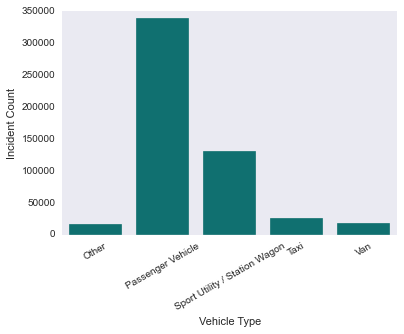

In [21]:
c_vtc1 = Counter(df["vehicle type code 1"])
sorted_c = sorted(c_vtc1.most_common(5))
x = [k for k,_ in sorted_c]
y = [v for _,v in sorted_c]
tmp = pd.DataFrame( 
    {
        "x": x,
        "y": y
    }
)

g = sns.barplot(x="x", y="y", data=tmp, color="teal")
g.set(xlabel='Vehicle Type', ylabel='Incident Count')
g.set_xticklabels(labels=x,rotation=30)
plt.show()

The same plot is made for the top 5 of factors named as `contributing factor vehicle 1` in the data set. This time, over half of the incidents denoted as `Unspecified` which is shame from an analysis point of perspective. As the second most common factor is `Driver Inattention/Distractiov` with more than twice as many as the third most, however, it does also seem like a pretty large category that you could imagine alot of incidents ending up in.

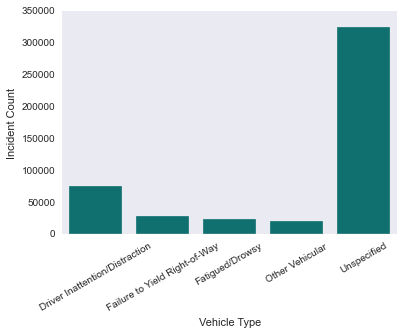

In [22]:
c_vfc1 = Counter(df["contributing factor vehicle 1"])
sorted_c = sorted(c_vfc1.most_common(5))
x = [k for k,_ in sorted_c]
y = [v for _,v in sorted_c]
tmp = pd.DataFrame( 
    {
        "x": x,
        "y": y
    }
)

g = sns.barplot(x="x", y="y", data=tmp, color="teal")
g.set(xlabel='Vehicle Type', ylabel='Incident Count')
g.set_xticklabels(labels=x,rotation=30)
plt.show()

Just some blocks used for preproccsing to csv files for the website

In [23]:
# lon and lat values taken from http://www.latlong.net
centroids_dict = {
                   "Bronx": [-73.864827, 40.844782],
                   "Brooklyn": [-73.944158,40.678178],
                   "Manhattan": [-73.971249, 40.783060],
                   "Queens": [-73.794852, 40.728224],
                   "Staten Island": [-74.150201,40.579532]
                  }
with open('borough_accident_count.csv', 'wb') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    filewriter.writerow(["Borough", "lon", "lat", "Total # of accidents"])
    for k in population_dict.keys():
        filewriter.writerow([k, centroids_dict[k][0], centroids_dict[k][1], accident_dict[k]])

In [24]:
# data for small bar chart    
for b in sorted(set(df["borough"])):
    with open('{}_contributing_factor_count.csv'.format(b), 'wb') as csvfile:
            filewriter = csv.writer(csvfile, delimiter=',')
            filewriter.writerow(["factor", "frequency"])

            accident_cause_df = df[df["borough"] == b]
            accident_cause_df = accident_cause_df[accident_cause_df["contributing factor vehicle 1"] != "Unspecified"]
            accident_cause_counter = Counter(accident_cause_df["contributing factor vehicle 1"])
            top5 = accident_cause_counter.most_common(5)
            for item in top5:
                filewriter.writerow([item[0], item[1]])

One could easily imagine, that the number of accidents is highly correlated by number of cars on the street. And the number of cars on the street must vary - especially on weekdays compared to weekends.Here is view of how all the incidents are distribtued on an hourly basis on the weekdays. The peaks around rush hour in the morning and in the afternoon is clearly visible.

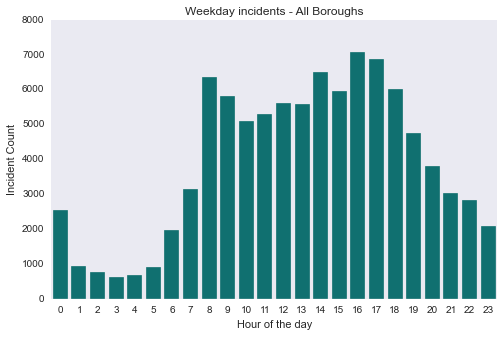

In [25]:
plt.rcParams["figure.figsize"] = (8,5)
df_2016_weekday = df[(df["year"] == 2016) & (df["weekday"].isin([0,1,2,3,4]))]

c_hours = Counter(df_2016_weekday["hour"])
c_hours_ints = sorted([(int(k),v) for (k,v) in c_hours.items()])
x,y = zip(*c_hours_ints)
df_counts1 = pd.DataFrame( 
    {
        "x": x,
        "y": y
    }
)

g = sns.barplot(x="x", y="y", data=df_counts1, color="teal")
g.set(xlabel='Hour of the day', ylabel='Incident Count', title="Weekday incidents - All Boroughs")
plt.show()

Next, here is the same view of the data, however, this time on weekends only. The peak is now only around afternoon, and relatively to the maximum peak there seem to be a lot more in the late evening and night hours. As an attentive reader, one might notice that the data is not only distributed differently - there is also a lot less accidents happening per hour. This was all expected since there obviously is not the same kind of rush hour when people do not have to go to work, the weekend only accomodates for 2 out of 7 days and a lot of people most likely spend there weekdends at home.

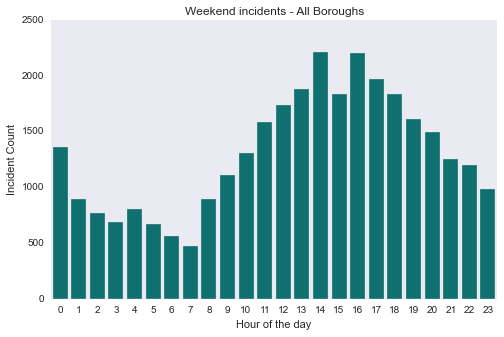

In [26]:
plt.rcParams["figure.figsize"] = (8,5)
df_2016_weekend = df[(df["year"] == 2016) & (df["weekday"].isin([5,6]))]

c_hours = Counter(df_2016_weekend["hour"])
c_hours_ints = sorted([(int(k),v) for (k,v) in c_hours.items()])
x,y = zip(*c_hours_ints)
df_counts2 = pd.DataFrame( 
    {
        "x": x,
        "y": y
    }
)

g = sns.barplot(x="x", y="y", data=df_counts2, color="teal")
g.set(xlabel='Hour of the day', ylabel='Incident Count', title="Weekend incidents - All Boroughs")
plt.show()

Now, since all the remaining incidents in the data set after a thorough cleaning has coordinates, it is time for plotting the data on maps.

In [27]:
# 
all_geodata = df[["lon", "lat", "borough", "year"]]
all_geodata = all_geodata.dropna(how="any")

# coordinates taken from http://boundingbox.klokantech.com

# best with a little cutoff in staten island in bronx
bbox_large = BoundingBox(40.930634, -74.297417,40.499703,-73.652718)
bbox_small = BoundingBox(40.887044,-74.332123,40.507013,-73.574066)

Because of the immense amount of incidents still left in the data set, plainly plotting the data on a map does not give much insigt because the is simply just dots everywhere the five borougs as seen below.

In [28]:
geoplotlib.set_bbox(bbox_large)
geoplotlib.tiles_provider("toner-lite")
geoplotlib.dot(color=[31, 120, 180], data=all_geodata)
geoplotlib.inline()

Therefore, a heat map as seen below will most likely yield more insight. Now it becomes evident that some areas are much more densly occupied on the map. The red "center" is in Downtown Manhattan.

In [29]:
geoplotlib.set_bbox(bbox_large)
geoplotlib.tiles_provider("toner-lite")
geoplotlib.kde(all_geodata, bw=5, cmap='coolwarm', cut_below=1e-4)
geoplotlib.inline()

('smallest non-zero count', 7.1647865443840454e-10)
('max count:', 91.708376877169513)


The data is splitted for more views, that will be shown on the website. Based on the heat map, Manhattan and Brooklyn are chosen as those two areas to look a little closer at. They both show highly dense areas.

In [30]:
brooklyn_geodata_all = all_geodata[all_geodata["borough"] == "Brooklyn"]
brooklyn_geodata_2012 = all_geodata[(all_geodata["borough"] == "Brooklyn") & (all_geodata["year"] == 2012)]
brooklyn_geodata_2013 = all_geodata[(all_geodata["borough"] == "Brooklyn") & (all_geodata["year"] == 2013)]
brooklyn_geodata_2014 = all_geodata[(all_geodata["borough"] == "Brooklyn") & (all_geodata["year"] == 2014)]
brooklyn_geodata_2015 = all_geodata[(all_geodata["borough"] == "Brooklyn") & (all_geodata["year"] == 2015)]
brooklyn_geodata_2016 = all_geodata[(all_geodata["borough"] == "Brooklyn") & (all_geodata["year"] == 2016)]

manhattan_geodata_all = all_geodata[all_geodata["borough"] == "Manhattan"]
manhattan_geodata_2012 = all_geodata[(all_geodata["borough"] == "Manhattan") & (all_geodata["year"] == 2012)]
manhattan_geodata_2013 = all_geodata[(all_geodata["borough"] == "Manhattan") & (all_geodata["year"] == 2013)]
manhattan_geodata_2014 = all_geodata[(all_geodata["borough"] == "Manhattan") & (all_geodata["year"] == 2014)]
manhattan_geodata_2015 = all_geodata[(all_geodata["borough"] == "Manhattan") & (all_geodata["year"] == 2015)]
manhattan_geodata_2016 = all_geodata[(all_geodata["borough"] == "Manhattan") & (all_geodata["year"] == 2016)]

Plotting the distribution of incidents involving `Taxi`s only, shows the picture you would expect with the most happening directly in Downtown Manhattan.

In [31]:
# checking for taxi accidents
taxi_geodata = df[df["vehicle type code 1"] == "Taxi"]
taxi_geodata = taxi_geodata[["lon", "lat", "borough", "year"]]

geoplotlib.set_bbox(bbox_small)
geoplotlib.tiles_provider("toner-lite")
geoplotlib.kde(taxi_geodata, bw=5, cmap='coolwarm', cut_below=1e-4)
geoplotlib.inline()

('smallest non-zero count', 7.1647865443840454e-10)
('max count:', 5.4058652164815131)


But one of the first most common contributing factors that does not rely on the drive or any other person in the traffic, is the `Pavement Slippery`. By plotting at heat map of this factor, it becomes evident, that some factors are not necesserarily directly correlated with the amount of incidents happening overall. In this case, new peaking locations become visible.

In [32]:
# checking for slippery pavement accidents
slippery_geodata = df[df["contributing factor vehicle 1"] == "Pavement Slippery"]
slippery_geodata = slippery_geodata[["lon", "lat", "borough", "year"]]

geoplotlib.set_bbox(bbox_small)
geoplotlib.tiles_provider("toner-lite")
geoplotlib.kde(slippery_geodata, bw=5, cmap='coolwarm', cut_below=1e-4)
geoplotlib.inline()

('smallest non-zero count', 2.8463276577810919e-06)
('max count:', 0.1680087681133117)


Another interesting thing would be to identify the intersections with the most incidents happening.

For this purpose a new helper function is created to split andsort `on street name` and `cross street name`

In [33]:
def sort_strings(concatenation):
    if type(concatenation) is str:
        streets = concatenation.split(",")
        sorted_streets = sorted(streets)
        return sorted_streets[0] + " , " + sorted_streets[1]
    else:
        return concatenation

In [34]:
# concatenating the two columns into one
df["intersection"] = df["on street name"] + "," + df["cross street name"] 

# split and sort the two streets names 
df["intersection"] = df["intersection"].apply(lambda x: sort_strings(x))

intersect_counter = Counter(df["intersection"])
top11 = intersect_counter.most_common(11)

Write the data to af file for the website.

In [35]:
with open('top10_intersections.csv', 'wb') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    filewriter.writerow(["intersection","count","lon", "lat"])
    for (intersection, count) in top11:
        if type(intersection) == float: continue # to skip firs NaN row
        temp_df = df[df["intersection"] == intersection]
        filewriter.writerow([intersection, count, temp_df.iloc[0]["lon"], temp_df.iloc[0]["lat"]])

Here is a view of the worst intersections in New York City. Five of them are located in Manhattan, but the five others a distributed throughout the city. None is represented in Staten Island, but otherwise would be surprising with the relative small amount of incidents happening in that borough.

In [36]:
top10_df = pd.read_csv("top10_intersections.csv")

geoplotlib.set_bbox(bbox_small)
geoplotlib.tiles_provider("toner-lite")
geoplotlib.markers(marker="pin.png", data=top10_df)
geoplotlib.inline()